In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from sklearn import linear_model

import torch
import torch.nn as nn
from torch.autograd import Variable
import folium
from folium import FeatureGroup, LayerControl, Map, Marker
from folium.plugins import HeatMap
from folium.plugins import TimestampedGeoJson
from folium.plugins import MarkerCluster

In [4]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [5]:
df_july = pd.read_csv('/content/gdrive/My Drive/Taxi Demand Prediction/Datasets/yellow_tripdata_2016-07.csv')

In [6]:
df_july.head()

VendorID  ...  total_amount
1 2016-07-10 06:56:05  2016-07-10 06:59:53  ...           NaN
2 2016-07-10 10:50:18  2016-07-10 10:55:21  ...           NaN
  2016-07-10 10:50:18  2016-07-10 11:08:38  ...           NaN
1 2016-07-10 10:50:19  2016-07-10 10:55:14  ...           NaN
  2016-07-10 10:50:19  2016-07-10 10:55:47  ...           NaN

[5 rows x 17 columns]

In [7]:
df_july.shape[0]

10294080

In [8]:
df_july = df_july.drop(['RatecodeID','payment_type','fare_amount','extra','mta_tax','tip_amount','tolls_amount','improvement_surcharge','total_amount'],1)

In [9]:
df_july.dropna(how = 'any', inplace = True)

In [ ]:
# taxi_carry = np.array(np.where(df_jan['passenger_count']>4))

In [10]:
df_july['pickup_datetime'] = pd.to_datetime(df_july['tpep_pickup_datetime'])

In [11]:
df_july['demand'] = df_july['passenger_count']*(df_july['trip_distance']) #demand ratio

In [12]:
df_july.to_csv('/content/gdrive/My Drive/Taxi Demand Prediction/Datasets/yellow_tripdata_2016-07_processed.csv')

In [13]:
df_july.head()

VendorID  ...  demand
1 2016-07-10 06:56:05  2016-07-10 06:59:53  ...       N
2 2016-07-10 10:50:18  2016-07-10 10:55:21  ...       N
  2016-07-10 10:50:18  2016-07-10 11:08:38  ...       N
1 2016-07-10 10:50:19  2016-07-10 10:55:14  ...       N
  2016-07-10 10:50:19  2016-07-10 10:55:47  ...       N

[5 rows x 10 columns]

In [14]:
X = df_july.drop(['VendorID','passenger_count','trip_distance','store_and_fwd_flag'], axis = 1)

y = df_july['demand']

In [15]:
cont_cols = ['PULocationID',
       'DOLocationID']
       
conts_data = np.stack([df_july[col].values for col in cont_cols], 1)

In [16]:
X = torch.tensor(conts_data, dtype = torch.float)

In [18]:
y = torch.tensor(df_july['demand'].values, dtype=torch.float).reshape(-1,1)

TypeError: ignored

In [ ]:
class LSTM1(nn.Module):
    """LSTM architecture"""

    def __init__(self, input_size, hidden_size, num_layers, seq_length=1):
        super(LSTM1, self).__init__()
        self.input_size = input_size  # input size
        self.hidden_size = hidden_size  # hidden state
        self.num_layers = num_layers  # number of layers
        self.seq_length = seq_length  # sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True,
                            dropout=0.1)
        self.fc_1 = nn.Linear(hidden_size, 16)  # fully connected 1
        self.fc_2 = nn.Linear(16, 8)  # fully connected 2
        self.fc = nn.Linear(8, 1)  # fully connected last layer

        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()

    def forward(self, x):
        """

        :param x: input features
        :return: prediction results
        """
        x = x.unsqueeze(0)
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))  # hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))  # internal state
        output, (hn, cn) = self.lstm(x, (h_0, c_0))  # lstm with input, hidden, and internal state

        hn_o = torch.Tensor(hn.detach().numpy()[-1, :, :])
        hn_o = hn_o.view(-1, self.hidden_size)
        hn_1 = torch.Tensor(hn.detach().numpy()[1, :, :])
        hn_1 = hn_1.view(-1, self.hidden_size)

        out = self.relu(self.fc_1(self.relu(hn_o + hn_1)))
        out = self.relu(self.fc_2(out))
        out = self.dropout(out)
        out = self.fc(out)
        return out


In [ ]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(GRUModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim

        # GRU layers
        self.gru = nn.GRU(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.unsqueeze(0)           #this removes the error "input must have 3 dimensions, got 2"
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.gru(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [ ]:
X.shape[1]

4

In [ ]:
model = LSTM1(X.shape[1], 16, 2)
model_2 = GRUModel(X.shape[1], 16, 2, 1, 0.1)

In [ ]:
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

In [ ]:
batch_size = 10000
test_size = int(batch_size * .2)

X_train = X[:batch_size-test_size]
X_test = X[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

torch.Size([8000, 4])
torch.Size([8000, 1])
torch.Size([2000, 4])
torch.Size([2000, 1])


In [ ]:
import time
start_time = time.time()

epochs = 10
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train) # RMSE
    losses.append(loss)
    
    
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') 
print(f'\nDuration: {time.time() - start_time:.0f} seconds') 

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([8000, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


epoch:   1  loss: 4.69094992
epoch:  10  loss: 4.21567631

Duration: 9 seconds


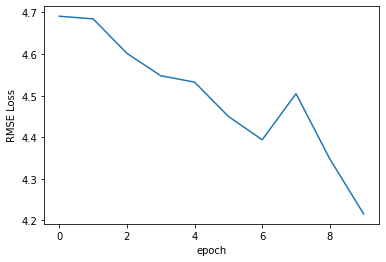

In [ ]:
plt.plot(range(epochs), losses)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch');

In [ ]:
with torch.no_grad():
    y_val = model(X_test)
    loss = torch.sqrt(criterion(y_val, y_test))
print(f'RMSE: {loss:.8f}')

RMSE: 2.06053257


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([2000, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


In [ ]:
import time
start_time = time.time()

epochs = 10
losses = []

for i in range(epochs):
    i+=1
    y_pred = model_2(X_train)
    loss = criterion(y_pred, y_train) # RMSE
    losses.append(loss)
    
    
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') 
print(f'\nDuration: {time.time() - start_time:.0f} seconds') 

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([8000, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


epoch:   1  loss: 4.37387133
epoch:  10  loss: 4.35498524

Duration: 32 seconds


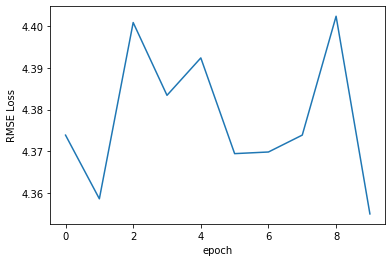

In [ ]:
plt.plot(range(epochs), losses)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch');

In [ ]:
with torch.no_grad():
    y_val = model_2(X_test)
    loss = torch.sqrt(criterion(y_val, y_test))
print(f'RMSE: {loss:.8f}')

RMSE: 2.11522794


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([2000, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


In [ ]:
import torch
def pf1(output,target,metric=None):
    d = output.data
    t = target.data
    TP = torch.nonzero(d*t).size(0)
    TN = torch.nonzero((d - 1) * (t - 1)).size(0)
    FP = torch.nonzero(d * (t - 1)).size(0)
    FN = torch.nonzero((d - 1) * t).size(0)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F1 = 2 * precision * recall / (precision + recall)
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    PPV = TP/(TP+FP)
    if metric=='precision':
        return precision
    elif metric=='recall':
        return recall
    elif metric=='PPV':
        return PPV
    elif metric=='accuracy':
        return accuracy
    else: return F1

In [ ]:
print(pf1(y_pred,y_train,metric='accuracy'))
print(pf1(y_pred,y_train,metric='precision'))
print(pf1(y_pred,y_train,metric='recall'))
print(pf1(y_pred,y_train,metric=None))

NameError: ignored